## Output has been removed from this notebook to reduce file sizes in the repo

In [25]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import pandana as pdna
from pandana.loaders import osm
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download OpenStreetMap restaurants for a good part of the Bay Area

###### Note: used http://boundingbox.klokantech.com/ to get the bounding box

In [26]:
# Bounding box from link above

# CSV for Aveiro
bbox = [-8.796616,40.561938,-8.517494,40.670744]
bbox = [bbox[1], bbox[0], bbox[3], bbox[2]]

network = osm.pdna_network_from_bbox(lat_min=bbox[0],lat_max=bbox[2],lng_min=bbox[1],lng_max=bbox[3],network_type='walk')
poi_df = osm.node_query(*bbox, tags='amenity=school')
x, y = poi_df['lon'], poi_df['lat']
# store = poi_df.


Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](40.56193800,-8.79661600,40.67074400,-8.51749400);>;);out;'}"
Downloaded 7,309.9KB from www.overpass-api.de in 1.49 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 1.84 seconds
Returning OSM data with 54,106 nodes and 8,734 ways...
Edge node pairs completed. Took 15.50 seconds
Returning processed graph with 10,987 nodes and 15,561 edges...
Completed OSM data download and Pandana node and edge table creation in 18.80 seconds


In [27]:
# Set pois for Network
network.set_pois('schools', 2000, 10, x,y)
network.precompute(2000)

## Nearest *point-of-interest* queries

In [28]:
a = network.nearest_pois(2000, "schools", num_pois=3)
a.head(10)

,1,2,3
id,,,
26019656,2000.000000,2000.000000,2000.000000
132887998,2000.000000,2000.000000,2000.000000
267983421,2000.000000,2000.000000,2000.000000
267983422,2000.000000,2000.000000,2000.000000
267983429,2000.000000,2000.000000,2000.000000
267983444,2000.000000,2000.000000,2000.000000
330341298,375.533997,464.529999,523.801025
330341301,585.379028,656.685974,670.331970
330341302,474.312012,545.619019,656.986023


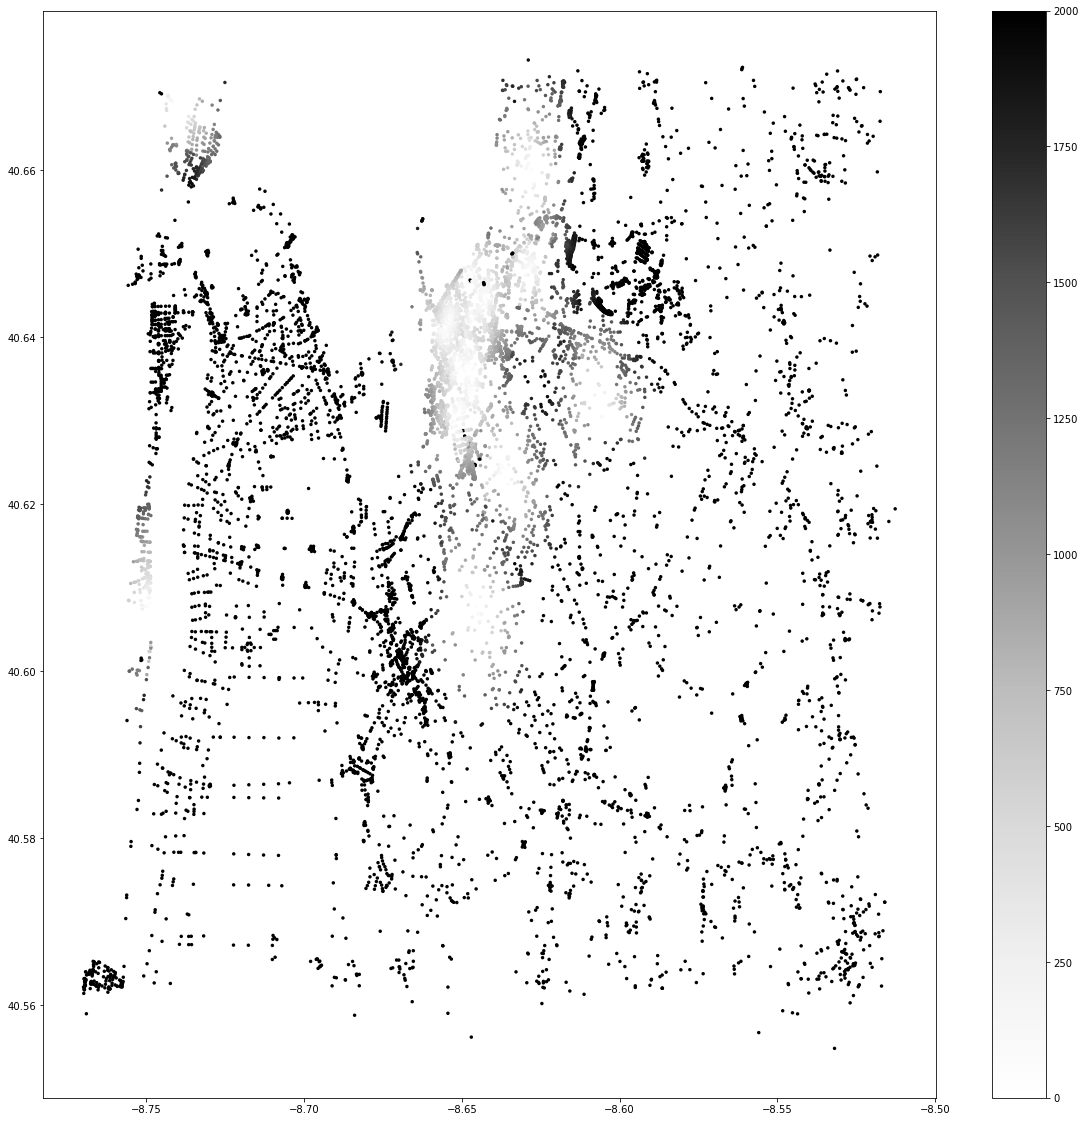

In [30]:
def plot_nearest_amenity(amenity,accessibility, n):
    fig_kwargs = {'figsize': [20, 20]}
    bmap_kwargs = {'suppress_ticks': False, 'resolution': 'h', 'epsg': '4326'}
    plot_kwargs = {'cmap': 'Greys', 's': 12, 'edgecolor': 'none'}
    fig, ax = network.plot(accessibility[n], bbox=bbox,
                               fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)
    ax.set_facecolor('k')
    ax.set_title('Pedestrian accessibility (Walking distance to {}, meters (n = {}))'.format(amenity,n), fontsize=14);

plot_nearest_amenity('schools',a,1)

## Here's a map of the distance to the 5th nearest restaurant

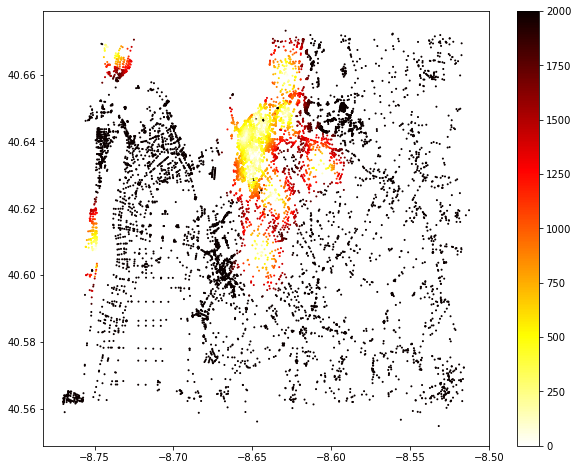

(<Figure size 720x576 with 2 Axes>, <AxesSubplot:>)

In [31]:
network.plot(a[1])

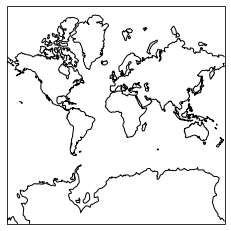

In [50]:
proj = ccrs.epsg(3857)
ax = plt.axes(projection=proj)

ax.coastlines()
plt.show()

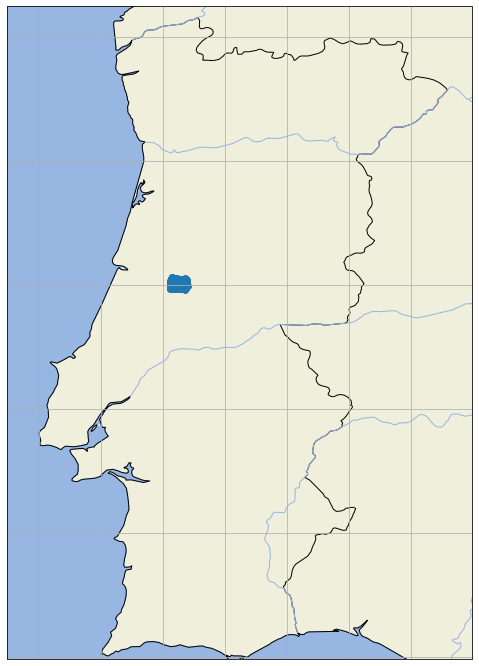

In [58]:
# Hardcoded way to plot with ccrs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import cartopy.feature as cfeature

# bbox = (net.nodes_df.x.min(), net.nodes_df.x.max() ,net.nodes_df.y.min(),net.nodes_df.y.max())

# For Portugal
portugal_east = -9.7558
portugal_west = -6.0095
portugal_south = 36.9850
portugal_north = 42.2427

# proj = ccrs.epsg(3857) # Test using 3857

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())

ax.set_extent([portugal_west,portugal_east,portugal_south,portugal_north])
# ax.set_extent([bbox[0],bbox[1],bbox[2],bbox[3]])


x,y = (net.nodes_df.x.values,net.nodes_df.y.values)
ax.scatter(x,y)

ax.gridlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES)

In [59]:
# testar esse exemplo: https://stackoverflow.com/questions/50611018/cartopy-heatmap-over-openstreetmap-background

## Here's a map of the distance to the 10th nearest restaurant

In [ ]:
net.plot(a[10], bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

# A similar workflow is used to do general network aggregations

## Relate the x-ys to nodes

In [13]:
node_ids = net.get_node_ids(x, y)

## Assign the variable (in this case just location) to the network

In [ ]:
net.set(node_ids)

## This is it - run the queries!

In [ ]:
%time s = net.aggregate(500, type="sum", decay="linear")
%time t = net.aggregate(1000, type="sum", decay="linear")
%time u = net.aggregate(2000, type="sum", decay="linear")
%time v = net.aggregate(3000, type="sum", decay="linear")
%time w = net.aggregate(3000, type="count", decay="flat")

## Here's a map of access to restaurants with a 500m radius

In [ ]:
net.plot(s, bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Or 1000 meters

In [ ]:
net.plot(t, bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Or 2000 meters radius

In [ ]:
net.plot(u, bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Or 3000m radius

In [ ]:
net.plot(v, bbox=sf_bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)

## Or the whole Bay Area region

In [ ]:
net.plot(w, bbox=bbox, 
         fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, plot_kwargs=plot_kwargs)